In [1]:
import os

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import graphviz

# hack omwille van bug in Id3Estimator
import six
import sys
!pip install decision-tree-id3
sys.modules['sklearn.externals.six'] = six
from id3 import Id3Estimator, export_graphviz, export_text

     |████████████████████████████████| 163kB 6.8MB/s 
  Created wheel for decision-tree-id3: filename=decision_tree_id3-0.1.2-cp37-none-any.whl size=15962 sha256=40ed99412588f09d853d553f99709f2d64a7cae4a4c1714ddc66f5512fafee16
  Stored in directory: /root/.cache/pip/wheels/2d/d6/f2/96cb2cc307503a88b1235aef5c794990e460bd044f382070f9
Successfully built decision-tree-id3


# The Simpsons

1.  Lees het bestand van de simpsons in (simpsons_nominal.csv)
Deze tabel bevat informatie over 9 karakters uit de Simpsons.
Deze dataset is al omgezet naar nominale meetwaarden.
We gaan onderzoeken of we 'geslacht' kunnen afleiden uit  haarlengte, gewicht en leeftijd

In [3]:
simpsons_nominal = pd.read_csv("datasets/simpsons_nominal.csv")
simpsons_nominal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   haarlengte  9 non-null      object
 1   gewicht     9 non-null      object
 2   leeftijd    9 non-null      object
 3   geslacht    9 non-null      object
dtypes: object(4)
memory usage: 416.0+ bytes


2.  Bereken zelf de entropie van deze tabel. Schrijf ook de formule op.

In [5]:
len_set = len(simpsons_nominal.geslacht)

#Voor 'geslacht'
print(f'\ngeslacht : {simpsons_nominal.geslacht.unique()}')
len_geslacht_M = len(simpsons_nominal[simpsons_nominal.geslacht == 'M'])
len_geslacht_V = len(simpsons_nominal[simpsons_nominal.geslacht == 'V'])
print(
    f'Er zijn {len_geslacht_V} instanties voor "V" en {len_geslacht_M} instanties voor "M" op een totaal van {len_set}')
entropie_geslacht = -len_geslacht_V /len_set* np.log2(len_geslacht_V / len_set) -len_geslacht_M /len_set * np.log2(len_geslacht_M / len_set)
print(f'De entropie van die kolom is dus {entropie_geslacht}')


def entropy(column: pd.Series, base=None):
    # Bepaal de fracties voor alle kolom waarden v
    fractions = column.value_counts(normalize=True, sort=False)
    base = 2 if base is None else base
    return -(fractions * np.log(fractions) / np.log(base)).sum()


# Check : bereken de entropie voor enkel 1 kolom
print(f'Entropie voor geslacht (met eigen functie): {entropy(simpsons_nominal.geslacht).round(4)}')

#De formule staat in  de cursus op hoofdstuk  4.1 Entropie


geslacht : ['M' 'V']
Er zijn 4 instanties voor "V" en 5 instanties voor "M" op een totaal van 9
De entropie van die kolom is dus 0.9910760598382222
Entropie voor geslacht (met eigen functie): 0.9911


3.  Bereken de gain voor iedere kolom.  
Kan je ook de gain van de laatste kolom berekenen?
Schrijf ook telkens de formule op?

In [ ]:
def information_gain(inputData: pd.DataFrame, columnName: str, targetName: str):
    # bepaal entropie van parent table
    entropy_parent = entropy(inputData[targetName])
    child_entropies = []
    child_weights = []
    # compute entropies of child tables
    for (label, fraction) in inputData[columnName].value_counts().items():
        child_df = inputData[inputData[columnName] == label]
        child_entropies.append(entropy(child_df[targetName]))
        child_weights.append(int(fraction))
    # calculate the difference between parent entropy and weighted child entropies
    return entropy_parent - np.average(child_entropies, weights=child_weights)


print("Initiële Information Gain voor alle kolommen")
targetVariable = 'geslacht'
inf_gain = {}
for label in simpsons_nominal.columns:
    if targetVariable != label:
        inf_gain[label] = information_gain(simpsons_nominal, label, targetVariable)
        print(f'{label: <12} {inf_gain[label]}')

Initiële Information Gain voor alle kolommen
haarlengte   0.45165906291896163
gewicht      0.5900048960119098
leeftijd     0.07278022578373256


4.  Bepaal de subtabel waarbij het gewicht altijd <=160 is.

In [ ]:
simpsons_licht = simpsons_nominal.loc[simpsons_nominal.gewicht == '<=160']
print(simpsons_licht)


  haarlengte gewicht leeftijd geslacht
1         >5   <=160    30-40        V
2         <3   <=160      <30        M
3         >5   <=160      <30        V
4        3-5   <=160      <30        V
6         >5   <=160      >40        V


5.  Wat is de entropie van deze subtabel?
En hoe verhoudt zich dat tov. entropie van de originele tabel?

In [ ]:
print(entropy(simpsons_licht.geslacht))
print(entropy(simpsons_nominal.geslacht))

print(f'Gain is {entropy(simpsons_nominal.geslacht) - entropy(simpsons_licht.geslacht)}')

0.7219280948873623
0.9910760598382221
Gain is 0.2691479649508598


6.  Bepaal de gain voor iedere kolom van deze subtabel.  
Welke kolom kies je dus voor de volgende stap?

In [ ]:
print('alle Gains for subtabel')
for label in simpsons_licht.columns:
    print('{:<12}  {}'.format(label, information_gain(simpsons_licht, label, 'geslacht')))

print('We kiezen daarna dus haarlengte')

alle Gains for subtabel
haarlengte    0.7219280948873623
gewicht       0.0
leeftijd      0.17095059445466854
geslacht      0.7219280948873623
We kiezen daarna dus haarlengte


7.  Maak de boomstructuur in Python

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:755: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  estimator=estimator)



gewicht <=160
|   haarlengte 3-5: V (1) 
|   haarlengte <3: M (1) 
|   haarlengte >5: V (3) 
gewicht >160: M (4) 



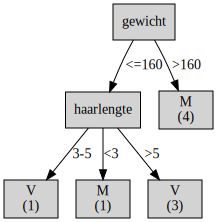

In [6]:
model = Id3Estimator()
# X = features, y = target
X = simpsons_nominal.drop(['geslacht'], axis=1).to_numpy().tolist()
y = simpsons_nominal['geslacht'].to_numpy().tolist()
model.fit(X, y)
print(export_text(model.tree_, feature_names=simpsons_nominal.drop(['geslacht'], axis=1).columns))

model_tree = export_graphviz(model.tree_, feature_names=simpsons_nominal.drop(columns=['geslacht']).columns)
graph = graphviz.Source(model_tree.dot_tree)
graph

8. Welk geslacht verwacht je voor een gloednieuw Simpson karakter met volgende eigenschappen?
 * haarlengte = '>5'
 * gewicht = '>160'
 * leeftijd = '30-40'

In [ ]:
Z = np.array([['>5', '>160', '30-40']])
display(model.predict(Z))
#==> Mannelijk

/usr/local/lib/python3.7/dist-packages/id3/id3.py:171: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  X = check_array(X)


array(['M'], dtype='<U1')

9. Extra : Probeer nu eens een DecisionTree op te stellen met DecisionTreeClassifier uit scikit-learn.tree

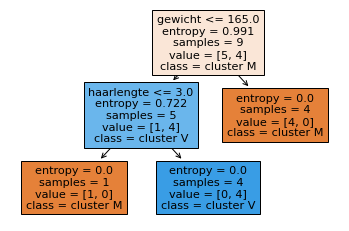

In [ ]:
'''DecisionTreeClassifier'''
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

simpsons = pd.read_csv("datasets/simpsons.csv")
classifier = DecisionTreeClassifier(criterion='entropy')
classifier.fit(simpsons.drop(['geslacht', 'naam'], axis=1), simpsons['geslacht'])

tree.plot_tree(classifier, feature_names=simpsons.drop(['geslacht', 'naam'], axis=1).columns.values,
               class_names=['cluster {}'.format(i) for i in
                            np.unique(simpsons['geslacht'])], filled=True)
plt.show()